# Data Pipeline: Webhallen GPU Inventory Scraper
This ipynb.file is serves as the automated data extraction and preprocessing engine for Webhallen's GPU inventory. Instead of relying on HTML parsing, this script connects directly to the retailer's backend API to securely and efficiently extract raw JSON payloads.

**Key features of this pipeline include:**
* **API-First Extraction:** Direct backend querying for maximum stability and speed.

* **Defensive Parsing:** Built-in fallback logic (`.get()`) to handle missing or malformed database entries without interrupting the scrape.

* **Automated Rate-Limiting:** Randomized sleep intervals to mimic human browsing behavior, preventing server overload and ensuring ethical scraping compliance.

* **Feature Engineering:** Heavy utilization of Regular Expressions (Regex) to extract and standardize hardware specifications (e.g., VRAM, Clock Speed, AIB Tier) from unstructured text strings.

The final output is a clean, structured CSV dataset ready for analysis!

In [4]:
# Import libraries
import json
import random
import time
import re
import requests
import pandas as pd

# STEP 1: API Interception & JSON Blueprinting

Rather than relying on fragile HTML parsing (e.g., searching for `<div>` tags), this scraper targets the retailer's backend API directly. This approach ensures the extraction pipeline is significantly faster, more stable, and highly resistant to front-end UI updates.

**Methodology: Locating the Backend API**
1. Open the browser's Developer Tools (`F12` or `Right Click -> Inspect`) and navigate to the `Network` tab.
2. Enable the `Fetch/XHR` filter to isolate raw database connections and API calls.
3. Force the website to load new data (e.g., by scrolling down the product page or applying a filter).
4. Inspect the newly loaded network requests to find the endpoint returning the clean JSON data payload. 
    * *Example API Endpoint:* `https://www.webhallen.com/api/productdiscovery/category/47?page=2&filters...`

       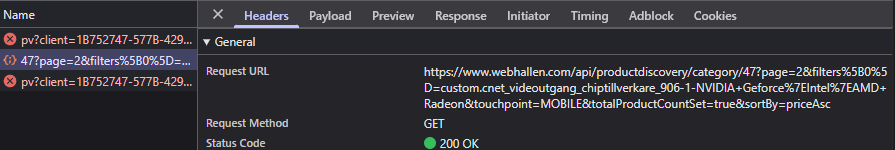      
    
5. **Data Mapping:** Once the correct API endpoint is identified, the next step is to map the JSON data structure to find the exact "keys" needed for the extraction script. You can do this using one of two methods:

    * **Option A (Browser):** Paste the API URL directly into your browser and utilize a JSON formatter extension or the native `Pretty-print` feature.
    
       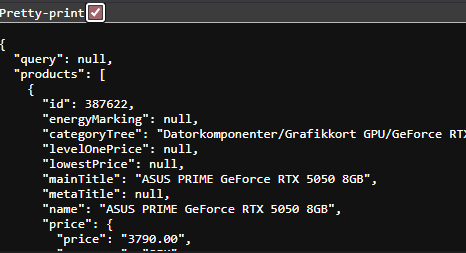

    * **Option B (Python):** Paste the API URL into the diagnostic script below. It will fetch and display the formatted JSON data tree directly in the output console.

       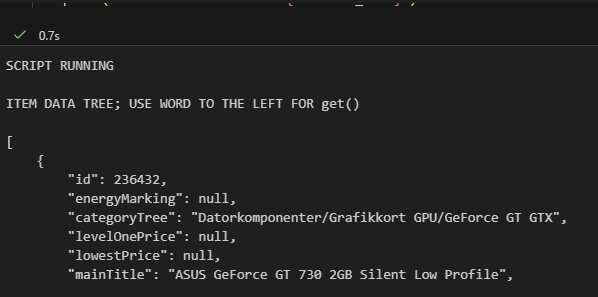

In [5]:
# Define the target API endpoint
target_api_url = "https://www.webhallen.com/api/productdiscovery/category/47?page=1&filters%5B0%5D=custom.cnet_videoutgang_chiptillverkare_906-1-NVIDIA+Geforce%7EAMD+Radeon%7EIntel&touchpoint=DESKTOP&totalProductCountSet=false&sortBy=priceAsc"

# Configure browser impersonation (Headers)
# This  mimics a standard Chrome browser on Windows to bypass basic anti-bot security protocols.
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36',
    'Accept-Language': 'sv-SE,sv;q=0.9,en-US;q=0.8,en;q=0.7',
    'Accept-Encoding': 'gzip, deflate, br',
    'Referer': 'https://www.google.se/', 
    'Sec-Ch-Ua': '"Not_A Brand";v="8", "Chromium";v="120", "Google Chrome";v="120"',
    'Sec-Ch-Ua-Mobile': '?0',
    'Sec-Ch-Ua-Platform': '"Windows"',
    'Sec-Fetch-Dest': 'document',
    'Sec-Fetch-Mode': 'navigate',
    'Sec-Fetch-Site': 'cross-site',
    'Sec-Fetch-User': '?1',
    'Upgrade-Insecure-Requests': '1',
    'Accept': 'application/json' # Content negotiation: Instructs the server to return the raw JSON payload rather than the HTML UI
          }

print("SCRIPT RUNNING: Finding JSON Blueprint\n")
r = requests.get(target_api_url, headers=headers)

# Checks Status
if r.status_code == 200:
    data = r.json()
    
    # Display first product to analyze the data structure
    items = data['products'][:1]
    
    # Output formatted JSON dictionary (Data Tree)
    print("ITEM DATA TREE (JSON BLUEPRINT)\n")
    print("Use the keys on the left side to build the extraction script.")
    print(json.dumps(items, indent=4))
else:
    print(f"Failed! Status Code: {r.status_code}")

SCRIPT RUNNING: Finding JSON Blueprint

ITEM DATA TREE (JSON BLUEPRINT)

Use the keys on the left side to build the extraction script.
[
    {
        "id": 236432,
        "energyMarking": null,
        "categoryTree": "Datorkomponenter/Grafikkort GPU/GeForce GT GTX",
        "levelOnePrice": null,
        "lowestPrice": null,
        "mainTitle": "ASUS GeForce GT 730 2GB Silent Low Profile",
        "metaTitle": null,
        "name": "ASUS GeForce GT 730 2GB Silent Low Profile",
        "price": {
            "price": "999.00",
            "currency": "SEK",
            "vat": 199.8,
            "type": null,
            "endAt": "2026-05-22T16:41:09",
            "startAt": "2026-02-11T15:52:11",
            "soldAmount": null,
            "maxAmountForPrice": null,
            "amountLeft": null,
            "nearlyOver": false,
            "flashSale": false,
            "maxQtyPerCustomer": null
        },
        "regularPrice": {
            "price": "999.00",
            "curr

# STEP 2: Data Extraction Engine
With the JSON data structure mapped, this core extraction loop programmatically iterates through the retailer's catalog. The loop is specifically engineered for resilience, scalability, and ethical scraping compliance.

* **Scalable Pagination:** Utilizes Python `f-strings` to dynamically update the `?page=` URL parameter, allowing the script to seamlessly iterate through the entire product catalog until an empty payload triggers the stop condition.

* **Defensive Parsing:** Employs Python's `.get()` dictionary method. If the backend database is missing a specific product attribute (e.g., a newly listed GPU lacking a review score), the script gracefully assigns a `None` value rather than throwing a `KeyError` and crashing the pipeline.

* **Ethical Rate Limiting:** Implements a randomized `time.sleep()` interval between network requests. This mimics natural human browsing patterns, mitigating server overload and bypassing basic bot-detection thresholds.

In [6]:
# Data storage and pagination settings
all_products = [] # memory storage for extracted product dictionaries
current_page = 1 # Pagination tracker. 
max_pages = 10 # Control limit for testing/execution

print("Starting the while loop...\n")

while current_page <= max_pages: 
    api_url = f"https://www.webhallen.com/api/productdiscovery/category/47?page={current_page}&filters%5B0%5D=custom.cnet_videoutgang_chiptillverkare_906-1-NVIDIA+Geforce%7EAMD+Radeon%7EIntel&touchpoint=DESKTOP&totalProductCountSet=false&sortBy=priceAsc"
    # Target API endpoint with dynamic f-string pagination

    print(f"Scraping Page {current_page}...")

    # Execute HTTP GET request 
    r = requests.get(api_url, headers=headers)
    
    # Status check: stop if connection fails
    if r.status_code != 200:
        print(f"ERROR, STATUS CODE: {r.status_code}")
        break

    # JSON parsing: Translate response into a searchable Python dictionary     
    data = r.json()
    products_list = data.get('products', [])
    
    # Stop condition: Exit loop when an empty product array is returned
    if len(products_list) == 0:
        print("No more products found")
        break

    print(f" -> Found {len(products_list)} GPUs on this page.")
    
    # Iterate through each product in the current pages payload (Sub-loop)
    for p in products_list:
        
        # 1. Basic info extraction
        product_id = p.get('id')
        name = p.get('name')
        subtitle = p.get('subTitle', '') 
        category_tree = p.get('categoryTree', '')
        
        # 2. Pricing extraction & conversion
        price_info = p.get('price', {})
        try:
            price = float(price_info.get('price', 0))
        except (ValueError, TypeError):
            price = None
            
        # 2.1. Discount calculation
        reg_price_info = p.get('regularPrice', {})
        if reg_price_info and reg_price_info.get('price'):
            reg_price = float(reg_price_info.get('price'))
        else:
            reg_price = price # Default to current price if no regular price exists

        discount = reg_price - price if (reg_price and price) else 0

        # 3. Review extraction
        review_count = p.get('reviewCount', 0)
        rating_info = p.get('averageRating') 
        
        if rating_info:
            try:
                rating = float(rating_info.get('rating', 0))
            except (ValueError, TypeError):
                rating = None
        else:
            rating = None
            
        # 4. Inventory (Web, Supplier, and Physical Stores)
        stock_info = p.get('stock', {})
        web_stock = stock_info.get('web', 0)
        
        supplier_stock = stock_info.get('supplier', 0)
        if supplier_stock is None:
            supplier_stock = 0
            
        # Dynamically aggregate physical store inventory across all retail locations    
        total_store_stock = 0
        for key, value in stock_info.items():
            if key.isdigit() and isinstance(value, int):
                total_store_stock += value

        total_stock = web_stock + supplier_stock + total_store_stock
        is_available = total_stock > 0 # Boolean for filtering

        # 5. Append structured product data to memory (dicitionary for each item)
        all_products.append({
            'ID': product_id,
            'Name': name,
            'Subtitle (Specs)': subtitle,
            'Category': category_tree,
            'Current Price (SEK)': price,
            'Regular Price (SEK)': reg_price,
            'Discount (SEK)': discount,
            'Rating': rating,
            'Review Count': review_count,
            'Web Stock': web_stock,
            'Supplier Stock': supplier_stock,
            'Store Stock': total_store_stock,
            'Total Stock': total_stock,
            'Is Available': is_available,
            'Date Scraped': time.strftime("%Y-%m-%d") # Time snapshot for historical trend analysis
                            })

    # Increment pagination counter    
    current_page += 1
    
    # Ethical rate limiting: Implement randomized sleep intervals to mimic human behavior
    sleep_time = random.uniform(1.5, 4.0)
    time.sleep(sleep_time)

print("\n SCRAPING COMPLETE. DATA IS NOW STORED IN RAM.")

Starting the while loop...

Scraping Page 1...
 -> Found 24 GPUs on this page.
Scraping Page 2...
 -> Found 24 GPUs on this page.
Scraping Page 3...
 -> Found 24 GPUs on this page.
Scraping Page 4...
 -> Found 24 GPUs on this page.
Scraping Page 5...
 -> Found 17 GPUs on this page.
Scraping Page 6...
No more products found

 SCRAPING COMPLETE. DATA IS NOW STORED IN RAM.


# STEP 3: Data Cleaning & Feature Engineering
Raw data is rarely primed for immediate analysis. In this stage, the extracted data is ingested into a **Pandas DataFrame** for cleaning and feature engineering. 

**Key transformations include:**
* **Regex Extraction:** Parsing unstructured text strings to isolate critical hardware specifications. Variables such as *VRAM*, *PCI Generation*, and *Clock Speed* are extracted and cast from strings (e.g., `"16 GB"`) into continuous numerical formats (`16.0`), enabling quantitative analysis.

* **Standardization:** Normalizing inconsistent GPU naming conventions across different manufacturers to create a clean, uniform `GPU Model` identifier.

* **Categorical Engineering:** Implementing custom business logic to classify Add-In Board (AIB) partners into strategic market tiers (*Halo, Performance, Value*) based on product naming structures.

In [7]:
# 1. Load the extracted product dictionaries into a Pandas DataFrame
df = pd.DataFrame(all_products)

# 2. Extracting VRAM using Regex
vram_from_name = df['Name'].str.extract(r'(\d+)\s*GB', flags=re.IGNORECASE, expand=False)
vram_from_sub = df['Subtitle (Specs)'].str.extract(r'(\d+)\s*GB', flags=re.IGNORECASE, expand=False)
df['VRAM (GB)'] = vram_from_name.fillna(vram_from_sub).astype(float)

# 3. Extract GPU manufacturer (NVIDIA/AMD/Intel)
df['Manufacturer'] = df['Subtitle (Specs)'].str.split('/').str[0].str.strip()

# 4. Extracting PCI Gen
df['PCI Gen'] = df['Subtitle (Specs)'].str.extract(r'(PCI Express [\d\.]+)', flags=re.IGNORECASE, expand=False)

# 5. Extracting clock speed (MHz)
df['Clock Speed (MHz)'] = df['Subtitle (Specs)'].str.extract(r'(\d+)\s*MHz', flags=re.IGNORECASE, expand=False).astype(float)

# 6. Extracting AIB partner (Brand) directly from product string
df['AIB'] = df['Name'].str.split().str[0]
df['AIB'] = df['AIB'].replace({'Asus': 'ASUS', 'Inno3d': 'INNO3D', 'Inno3D': 'INNO3D'})

# 7. Isolate base GPU model using Regex
gpu_pattern = r'(RTX\s\d{4}(?:\s?Ti|\s?SUPER|\s?Ti\s?SUPER)?|GTX\s\d{3,4}(?:\s?Ti)?|GT\s\d{3,4}|RX\s\d{4}(?:\s?XTX|\s?XT|\s?GRE)?|Arc\s?[A-Z]\d{3})'
df['GPU Model'] = df['Name'].str.extract(gpu_pattern, flags=re.IGNORECASE, expand=False)

# 8. Standardize GPU formatting
df['GPU Model'] = (df['GPU Model']
                   .str.title()
                   .str.replace(r'(\d{4})Ti', r'\1 Ti', regex=True, flags=re.IGNORECASE)
                   .str.replace(r'Rtx', 'RTX').str.replace(r'Gtx', 'GTX').str.replace(r'Gt ', 'GT ')
                   .str.replace(r'Rx', 'RX').str.replace('Xtx', 'XTX').str.replace('Xt', 'XT').str.replace('Gre', 'GRE')
                   .str.strip())

# 9. Combining model and VRAM into a unique identifier
# We fill NaN VRAMs with 0 temporarily so the string concatenation doesnt crash
safe_vram = df['VRAM (GB)'].fillna(0).astype(int).astype(str) + "GB"
df['GPU Model'] = df['GPU Model'] + " " + safe_vram

# 10. Clean up: Drop items that aren't actually GPUs (Regex found nothing)
df = df.dropna(subset=['GPU Model']).reset_index(drop=True)

# 11. Categorize AIB sub-brands to strategic market tiers 
def categorize_tier(name):
    name = str(name).upper()
    if any(x in name for x in ['ASTRAL', 'STRIX', 'SUPRIM', 'AORUS', 'NITRO+', 'RED DEVIL', 'WATERFORCE', 'VULCAN', 'LIQUID', 'TAICHI', 'NOCTUA']):
        return 'Halo'        
    elif any(x in name for x in ['TUF', 'GAMING TRIO', 'GAMING X', 'GAMING OC', 'PHANTOM GAMING', 'STEEL LEGEND', 'PULSE', 'HELLHOUND', 'AERO', 'PROART', 'GUARDIAN']):
        return 'Performance'     
    elif any(x in name for x in ['PRIME', 'DUAL', 'VENTUS', 'WINDFORCE', 'EAGLE', 'FIGHTER', 'VERTO', 'GHOST', 'SILENT', 'CHALLENGER', 'ORC', 'X3', 'LOW PROFILE', 'LP BRK']):
        return 'Value'
    elif 'GAMING' in name:
        return 'Performance'       
    return 'Uncategorized'

df['AIB Tier'] = df['Name'].apply(categorize_tier)

print(f"Total items ready for analysis: {len(df)}")
display(df.head(1))

Total items ready for analysis: 113


,ID,Name,Subtitle (Specs),Category,Current Price (SEK),Regular Price (SEK),Discount (SEK),Rating,Review Count,Web Stock,...,Total Stock,Is Available,Date Scraped,VRAM (GB),Manufacturer,PCI Gen,Clock Speed (MHz),AIB,GPU Model,AIB Tier
0,236432,ASUS GeForce GT 730 2GB Silent Low Profile,NVIDIA Geforce / PCI Express 2.0 / 902 MHz,Datorkomponenter/Grafikkort GPU/GeForce GT GTX,999.0,999.0,0.0,5.0,4.0,0,...,0,False,2026-02-23,2.0,NVIDIA Geforce,PCI Express 2.0,902.0,ASUS,GT 730 2GB,Value


### 3.1: Data Export
The DataFrame is now exported to a CSV file. The filename is dynamically time stamped, allowing for version control and price trend analysis.

In [8]:
# Export to CSV
csv_filename = f'webhallen_gpus_{time.strftime("%Y%m%d")}.csv'
df.to_csv(csv_filename, index=False, encoding='utf-8-sig')
print(f"\nSaved data to {csv_filename}")


Saved data to webhallen_gpus_20260223.csv
